In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
import torch

from utils.data_transform import Sentinel2Transform
from utils.sentinel_2_reader import S2Reader
from utils.data_loader import DataLoader

In [2]:
from torch.optim import Adam
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn import NLLLoss
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix

from utils import train_valid_eval_utils as tveu
import shutil

# Data Download

In [4]:
from radiant_mlhub import Dataset

os.environ['MLHUB_API_KEY'] = '380ab1acf08f82cddc417ddaf61b6acbaceb0e6a125435e63b79d93efe0110c6'

if not os.path.exists('data/'):
    os.makedirs('data/')

In [3]:
# Brandenburg dataset
dataset = Dataset.fetch('dlr_fusion_competition_germany')
print(f'{dataset.id}: {dataset.title}')
dataset.download('data/')

NameError: name 'Dataset' is not defined

In [6]:
#South Africa dataset
dataset = Dataset.fetch('ref_fusion_competition_south_africa')
print(f'{dataset.id}: {dataset.title}')
dataset.download('data/')

ref_fusion_competition_south_africa: A Fusion Dataset for Crop Type Classification in Western Cape, South Africa


INFO:radiant_mlhub.client.catalog_downloader:unarchive ref_fusion_competition_south_africa.tar.gz ...
unarchive ref_fusion_competition_south_africa.tar.gz: 100%|██████████| 1792/1792 [00:00<00:00, 57352.31it/s]
INFO:radiant_mlhub.client.catalog_downloader:create stac asset list (please wait) ...
INFO:radiant_mlhub.client.catalog_downloader:1658 unique assets in stac catalog.
download assets: 100%|██████████| 1658/1658 [00:05<00:00, 280.47it/s]
INFO:radiant_mlhub.client.catalog_downloader:assets saved to data\ref_fusion_competition_south_africa


In [ ]:
brandenburg_tr_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/vector_labels.geojson'
brandenburg_te_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_test_labels/dlr_fusion_competition_germany_test_labels_33N_17E_243N/vector_labels.geojson'

In [ ]:
brandenburg_tr_labels=gpd.read_file(brandenburg_tr_labels_dir)
print('INFO: Number of fields: {}\n'.format(len(brandenburg_tr_labels)))
brandenburg_tr_labels.info()
brandenburg_tr_labels.tail()

In [ ]:
label_ids=brandenburg_tr_labels['crop_id'].unique()
label_names=brandenburg_tr_labels['crop_name'].unique()

print('INFO: Label IDs: {}'.format(label_ids))
print('INFO: Label Names: {}'.format(label_names))

In [ ]:
value_counts=brandenburg_tr_labels['crop_name'].value_counts()

colors_list = ['#78C850','#A8B820','#F8D030','#E0C068', '#F08030', '#C03028', '#F85888','#6890F0','#98D8D8'] 
ax=value_counts.plot.bar(color=colors_list)
ax.set_ylabel("Number of Fields")
ax.set_xlabel("Crop Types")

print('INFO: Number of Fields by Crop Type: \n{}'.format(value_counts))

# Exploring S2 Data

In [ ]:
brandenburg_s2_train_dir = "data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018"

In [ ]:
#INITIALIZE THE DATA READER TO OBSERVE THE FIELDS FROM PLANET DATA: 

# Choose some days of the year to plot
selected_data_indices = range(143) #beware that S2 data is not daily, 

#Initialize data reader for planet images
s2_reader = S2Reader(input_dir=brandenburg_s2_train_dir,
                                  label_dir=brandenburg_tr_labels_dir,
                                  selected_time_points=selected_data_indices)

# Working with Sentinel 2 Data

In [22]:
brandenburg_s2_train_dir = "data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/"
brandenburg_tr_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/vector_labels.geojson'

In [23]:
import numpy as np

# Load the .npz file
data = np.load("data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/fid_210180.npz")

# Check the available data indices
print(data.files)
# available_indices = data['image_stack']
print(len(data['image_stack']))
# print("Available data indices:", available_indices)


['image_stack', 'cloud_stack', 'mask', 'feature']
144


In [ ]:
def true_color(X):
    blue = X[1]/(X[1].max()/255.0)
    green = X[2]/(X[2].max()/255.0)
    red = X[3]/(X[3].max()/255.0)
    tc = np.dstack((red,green,blue)) 
    
    return tc.astype('uint8')

def ndvi(X):
    red = X[3]
    nir = X[7]
    return (nir-red) / (nir + red)

def endvi(X):
    B8 = X[7]
    B4 = X[3]
    B2 = X[1]
    return 2.5 * ((B8 - B4) / (B8 + 6 * B4 - 7.5 * B2 + 1))

In [ ]:
# Selected_time_interval can be left empty to exploit all available time points
s2_reader = S2Reader(input_dir=brandenburg_s2_train_dir, label_dir=brandenburg_tr_labels_dir)

crop_id, crop_name = label_ids[7], label_names[0]

In [ ]:
# Print Median value of each field for all days
median = []
days = []
iterable = iter(s2_reader)
while True:
    X, y, mask, _ = next(iterable)

    width = X.shape[-1]
    height = X.shape[-2]

    if y == crop_id and width > 60 and height > 60:
        for day in range(143):
            median.append(np.median(ndvi(X[day])))
            days.append(day)

        break

In [ ]:
plt.plot(days, median)
plt.show

# Preparing Sentinel 2 data (Brandenburg)

In [3]:
brandenburg_s2_train_dir = "data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/"
brandenburg_tr_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/vector_labels.geojson'

brandenburg_tr_labels=gpd.read_file(brandenburg_tr_labels_dir)
label_ids=brandenburg_tr_labels['crop_id'].unique()
label_names=brandenburg_tr_labels['crop_name'].unique()

In [4]:
zipped_lists = zip(label_ids, label_names)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
label_ids, label_names = [ list(tuple) for tuple in  tuples]

In [5]:
sentinel_2_transformer=Sentinel2Transform()
s2_reader = S2Reader(input_dir=brandenburg_s2_train_dir, label_dir=brandenburg_tr_labels_dir, label_ids=label_ids, transform=sentinel_2_transformer.transform, min_area_to_ignore=1000)

data_loader=DataLoader(train_val_reader=s2_reader, validation_split=0.25)

INFO: Ignoring 30/2534 fields with area < 1000m2


INFO: Extracting time series into the folder: data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/: 100%|██████████| 2504/2504 [00:00<00:00, 8594.34it/s]


In [7]:
train_loader=data_loader.get_train_loader(batch_size=8, num_workers=1)
valid_loader=data_loader.get_validation_loader(batch_size=8, num_workers=1)

INFO: Training data loader initialized.
INFO: Validation data loader initialized.


In [8]:
torch.cuda.is_available()

True

# Preparing Sentinel 2 data (South Africa)

In [43]:
south_africa_s2_train_dir_1 = "data/ref_fusion_competition_south_africa/ref_fusion_competition_south_africa_train_source_sentinel_2/ref_fusion_competition_south_africa_train_source_sentinel_2_34S_19E_258N_34S_19E_258N_2017/"
south_africa_tr_labels_dir_1= "data/ref_fusion_competition_south_africa/ref_fusion_competition_south_africa_train_labels/ref_fusion_competition_south_africa_train_labels_34S_19E_258N/vector_labels.geojson"

south_africa_s2_train_dir_2 = "data/ref_fusion_competition_south_africa_train_source_sentinel_2/ref_fusion_competition_south_africa_train_source_sentinel_2_34S_19E_259N_34S_19E_259N_2017/"
south_africa_tr_labels_dir_2= "data/ref_fusion_competition_south_africa_train_labels/ref_fusion_competition_south_africa_train_labels_34S_19E_259N/vector_labels.geojson"


south_africa_tr_labels_1=gpd.read_file(south_africa_tr_labels_dir_1)
label_ids=south_africa_tr_labels_1['crop_id'].unique()
label_names=south_africa_tr_labels_1['crop_name'].unique()

In [44]:
zipped_lists = zip(label_ids, label_names)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
label_ids, label_names = [ list(tuple) for tuple in  tuples]

In [ ]:
#Get data transformer for S2 images
sentinel_2_transformer=Sentinel2Transform()

#Initialize data reader for S2 images
s2_reader = S2Reader(input_dir=south_africa_s2_train_dir_1,
                             label_dir=south_africa_tr_labels_dir_1,
                             label_ids=label_ids,
                             transform=sentinel_2_transformer.transform,
                             min_area_to_ignore=1000)

#Initialize data loaders
data_loader=DataLoader(train_val_reader=s2_reader, validation_split=0.25)
train_loader=data_loader.get_train_loader(batch_size=8, num_workers=1)
valid_loader=data_loader.get_validation_loader(batch_size=8, num_workers=1)

# CNN LSTM Model

In [36]:
import models
import importlib

importlib.reload(models)

INPUT_DIM = 5
DEVICE = 'cuda'
#sequence lenth = 144 total?
SEQUENCE_LENGTH=140
START_EPOCH=0
TOTAL_EPOCH=3

# models.test()

brandenburg_model = models.CNNLSTM(input_dim=INPUT_DIM, num_classes=len(label_ids), device=DEVICE)
print(brandenburg_model)

INFO: model initialized with name:Conv3d_LSTM_5_asdfa
CNNLSTM(
  (cnn): Sequential(
    (0): Conv3d(5, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(1024, 9, batch_first=True)
)


In [37]:
optimizer = SGD(brandenburg_model.parameters(), lr=1e-3, momentum=0.9,nesterov=False)
loss_criterion = CrossEntropyLoss()

In [38]:
# Logging results
log = list()
log_root='temp_s2/'
logdir = os.path.join(log_root, brandenburg_model.modelname)
os.makedirs(logdir, exist_ok=True)
print("INFO: Logging results will be saved to {}".format(logdir))
summarywriter = SummaryWriter(log_dir=logdir)
snapshot_path = os.path.join(logdir, "model.pth.tar")

INFO: Logging results will be saved to temp_s2/Conv3d_LSTM_5_asdfa


In [39]:
# Resume training if stopped midway ?
snapshot_path = os.path.join(logdir, "model.pth.tar")
if os.path.exists(snapshot_path):
    checkpoint = torch.load(snapshot_path)
    START_EPOCH = checkpoint["epoch"]
    log = checkpoint["log"]
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    brandenburg_model.load_state_dict(checkpoint["model_state"])
    print(f"INFO: Resuming from {snapshot_path}, epoch {START_EPOCH}")

valid loss=2.04: 100%|██████████| 79/79 [00:12<00:00,  6.53it/s]


INFO: epoch 0: train_loss 2.65, valid_loss 2.16 accuracy=0.21, kappa=-0.01, f1_micro=0.21, f1_macro=0.09, f1_weighted=0.17, recall_micro=0.21, recall_macro=0.12, recall_weighted=0.21, precision_micro=0.21, precision_macro=0.12, precision_weighted=0.21


valid loss=1.97: 100%|██████████| 79/79 [00:12<00:00,  6.49it/s]


INFO: epoch 1: train_loss 2.07, valid_loss 2.12 accuracy=0.38, kappa=-0.00, f1_micro=0.38, f1_macro=0.07, f1_weighted=0.23, recall_micro=0.38, recall_macro=0.11, recall_weighted=0.38, precision_micro=0.38, precision_macro=0.06, precision_weighted=0.17


valid loss=1.93: 100%|██████████| 79/79 [00:11<00:00,  6.73it/s]

INFO: epoch 2: train_loss 2.01, valid_loss 2.12 accuracy=0.39, kappa=0.00, f1_micro=0.39, f1_macro=0.06, f1_weighted=0.22, recall_micro=0.39, recall_macro=0.11, recall_weighted=0.39, precision_micro=0.39, precision_macro=0.04, precision_weighted=0.15


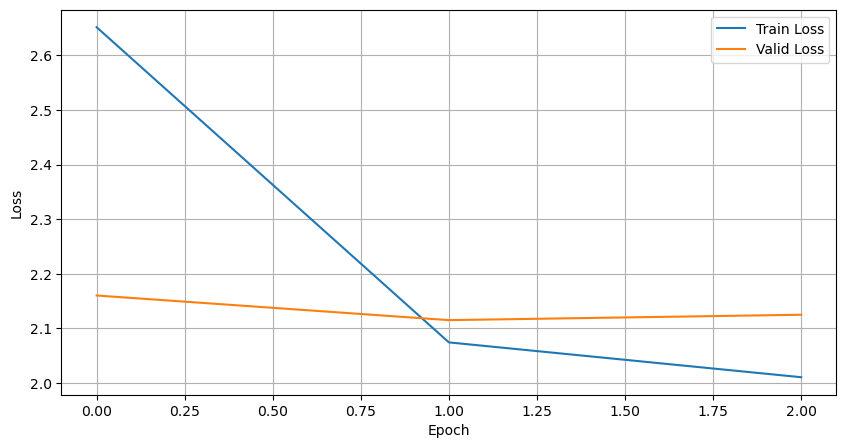

In [40]:
train_losses = []
valid_losses = []

for epoch in range(START_EPOCH, TOTAL_EPOCH):
    train_loss = tveu.train_epoch(brandenburg_model, optimizer, loss_criterion, train_loader, device=DEVICE)
    valid_loss, y_true, y_pred, *_ = tveu.validation_epoch(brandenburg_model, loss_criterion, valid_loader, device=DEVICE)
    
    
    scores = tveu.metrics(y_true.cpu(), y_pred.cpu())
    
    scores_msg = ", ".join([f"{k}={v:.2f}" for (k, v) in scores.items()])
    
    valid_loss = valid_loss.cpu().detach().numpy()[0]
    train_loss = train_loss.cpu().detach().numpy()[0]

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    scores["epoch"] = epoch
    scores["train_loss"] = train_loss
    scores["valid_loss"] = valid_loss
    log.append(scores)

    summarywriter.add_scalars("losses", dict(train=train_loss, valid=valid_loss), global_step=epoch)
    summarywriter.add_scalars("metrics",
                              {key: scores[key] for key in
                               ['accuracy', 'kappa', 'f1_micro', 'f1_macro', 'f1_weighted', 
                                'recall_micro','recall_macro', 'recall_weighted', 
                                'precision_micro', 'precision_macro','precision_weighted']},
                                global_step=epoch)

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred.cpu().detach().numpy(), labels=np.arange(len(label_ids)))
    summarywriter.add_figure("confusion_matrix",tveu.confusion_matrix_figure(cm, labels=label_ids),global_step=epoch)

    log_df = pd.DataFrame(log).set_index("epoch")
    log_df.to_csv(os.path.join(logdir, "train_log.csv"))

    torch.save(dict( model_state=brandenburg_model.state_dict(),optimizer_state=optimizer.state_dict(), epoch=epoch, log=log),snapshot_path)
    if len(log) > 2:
        if valid_loss < np.array([l["valid_loss"] for l in log[:-1]]).min():
            best_model = snapshot_path.replace("model.pth.tar","model_best.pth.tar")
            print(f"INFO: New best model with valid_loss {valid_loss:.2f} at {best_model}")
            shutil.copy(snapshot_path, best_model)

    print(f"INFO: epoch {epoch}: train_loss {train_loss:.2f}, valid_loss {valid_loss:.2f} " + scores_msg)

plt.figure(figsize=(10, 5))
plt.plot(range(START_EPOCH, TOTAL_EPOCH), train_losses, label='Train Loss')
plt.plot(range(START_EPOCH, TOTAL_EPOCH), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()